In [1]:
cd /home/lansdell/projects/synthfeedback

/home/lansdell/projects/synthfeedback


In [2]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
import numpy as np
import numpy.random as rand
from numpy import random as rng
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import argparse
import seaborn as sns
from utils.utils import tf_matmul_r, tf_matmul_l
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


## Cartpole RNN

In [3]:
#method = args.method
#save = bool(args.save)

method = 'backprop'
save = False

anneal = True

# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 20
in_dim = 4
state_size = 50
learning_rate = 1e-3
alpha2 = 1
activation = tf.tanh
act_prime = lambda x: 1 - tf.multiply(x,x)

#Node pert params
lmbda = 5e-5
var_xi = 0.5
p_fire = 0.1 #prob of firing

acclimatize = True

grad_max = 10

N_epochs = 1000
N_episodes = 10

report_rate = 100
fn_out = './experiments/cartpole_rnn_np/%s_learning_rate_%f_lmbda_%f_varxi_%f.npz'%(method, learning_rate, lmbda, var_xi)

#Things to save with output
params = {
'num_steps': num_steps,
'batch_size': batch_size,
'in_dim': in_dim,
'state_size': state_size,
'learning_rate': learning_rate,
'alpha2': alpha2,
'lmbda': lmbda,
'var_xi': var_xi,
'p_fire': p_fire,
'grad_max': grad_max,
'N_epochs': N_epochs,
'N_episodes': N_episodes,
'acclimatize':acclimatize
}

#method = 'backprop'
#method = 'feedbackalignment'
#method = 'nodepert'
#method = 'weightsym'

print("Using %s"%method)
print("For %d epochs"%N_epochs)
print("Learning rate: %f"%learning_rate)
print("Lambda learning rate: %f"%lmbda)
print("Variance xi: %f"%var_xi)
print("Saving results: %d"%save)

Using backprop
For 1000 epochs
Learning rate: 0.001000
Lambda learning rate: 0.000050
Variance xi: 0.500000
Saving results: 0


In [4]:
def rnn_cell(rnn_input, state, W, U):
    ones0 = tf.ones([batch_size, 1], tf.float32)
    state_p = tf.concat([state, ones0], 1)
    return activation(tf.matmul(rnn_input, U) + tf.matmul(state_p, W))

## Set up training procedure

In [5]:
def train_network(num_episodes, num_steps, state_size=state_size, verbose=True):
    xs = np.zeros((N_epochs, num_episodes, num_steps, batch_size, in_dim))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        alignments = []

        for idx in range(N_epochs):
            print("Epoch: %d"%idx)
            #if idx < 4 and acclimatize:
            #    ts = train_step_B
            #else:
            ts = train_step
            training_loss = 0
            training_x = np.zeros((batch_size, in_dim))
            #training_x = 2*rng.randn(batch_size, in_dim)
            #training_x[:,1] = np.pi
            training_state = np.zeros((batch_size, state_size))
            for step in range(num_episodes):
                tr_init_gradW = np.zeros((state_size+1, state_size))
                tr_init_gradB = np.zeros((state_size, state_size))
                tr_init_gradU = np.zeros((in_dim, state_size))
                tr_loss, tr_losses, training_loss_, training_state, training_x, _, align, x_o = \
                    sess.run([loss, losses, total_loss, final_state, final_x, ts, aments, rnn_inputs], \
                                  feed_dict={init_state:training_state, init_x: training_x, \
                                  init_gradU: tr_init_gradU, init_gradW: tr_init_gradW, \
                                  init_gradB: tr_init_gradB})
                #print(np.array(x_o).shape)
                xs[idx, step, :, :, :] = np.array(x_o)[:,:,:]
                training_loss += training_loss_
                if step % report_rate == 0 and step > 0:
                    if verbose:
                        print("Average loss at step %d for last %d steps: %f"%(step, report_rate, \
                                                                               training_loss/report_rate))
                    training_losses.append(training_loss/report_rate)
                    alignments.append(align)
                    training_loss = 0

    return training_losses, step, alignments, xs

In [6]:
##############
## BACKPROP ##
##############

def backprop():

    grad_U = init_gradU
    grad_W = init_gradW
    grad_B = init_gradB
    alnments = []
    for i in range(num_steps):
        for j in range(i+1)[::-1]:
            if j == i:
                delta = tf.multiply(tf.matmul(delta0s[i][:,None],tf.transpose(V[0:state_size,:])), \
                                    act_prime(rnn_outputs[j]))
            else:
                delta = tf.multiply(tf.matmul(delta, tf.transpose(W[0:state_size,:])), act_prime(rnn_outputs[j]))
            grad_U = grad_U + tf.matmul(tf.transpose(rnn_inputs[j]), delta)
            if j > 0:
                grad_W = grad_W + tf.matmul(tf.transpose(tf.concat([rnn_outputs[j-1], ones0],1)), delta)

    grad_V = tf.gradients(xs=V, ys=total_loss)[0]
    #grad_W = tf.gradients(xs=W, ys=total_loss)[0]
    #grad_U = tf.gradients(xs=U, ys=total_loss)[0]

    return grad_U, grad_W, grad_B, grad_V, alnments

In [7]:
if method == 'backprop':
    trainer = backprop
elif method == 'feedbackalignment':
    trainer = feedbackalignment
elif method == 'nodepert':
    trainer = nodepert
elif method == 'weightsym':
    trainer = weightsym
else:
    raise NotImplementedError

init_x = tf.zeros([batch_size, in_dim], dtype=np.float32)
init_state = tf.zeros([batch_size, state_size], dtype=np.float32)
init_gradW = tf.zeros([state_size+1, state_size], dtype=np.float32)
init_gradB = tf.zeros([state_size, state_size], dtype=np.float32)
init_gradU = tf.zeros([in_dim, state_size], dtype=np.float32)
alignment = tf.zeros([in_dim, state_size], dtype=np.float32)

ones0 = tf.ones([batch_size, 1], tf.float32)
#U = tf.get_variable('U', [in_dim, state_size])
#W = tf.get_variable('W', [state_size+1, state_size])
#V = tf.get_variable('V', [state_size+1, 1])
U = tf.Variable(rng.randn(in_dim, state_size)*alpha2, name="input_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(state_size+1, state_size)*alpha2, name="feedforward_weights", dtype=tf.float32)
#W = tf.Variable(np.zeros((state_size+1, state_size))*alpha2, name="feedforward_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(state_size, state_size)*alpha2, name="feedback_weights", dtype=tf.float32)
V = tf.Variable(rng.randn(state_size+1, 1)*alpha2, name="output_weights", dtype=tf.float32)

## Define the pole task and dynamics here

In [8]:
x = init_x
state = init_state
state_p = init_state
rnn_inputs = []
rnn_outputs = []
rnn_pert_outputs = []
noise_outputs = []
heights = []
hs = []
actions = []

#Cart pole dynamics simulated for num_steps 
m = 1.1
mp = 0.1
g = 9.8
l = 0.5
tau = 0.04
Fmax = 10
max_h = 3
gamma = 10

#Equations of motion:
#theta_dd = (m*g*sin(theta) - cos(theta)*(F + mp*l*theta_d*theta_d*sin(theta)))/((4/3)*m*l - mp*l*cos(theta)*cos(theta))
#theta_d += tau*theta_dd
#theta += tau*theta
#h_dd = (F + mp*l*(theta_d*theta_d*sin(theta)-theta_dd*cos(theta)))/m
#h_d += tau*h_dd
#h += tau*h_d

for idx in range(num_steps):
    mask = tf.random_uniform(state.shape) < p_fire
    xi = tf.multiply(tf.random_normal(state.shape)*var_xi, tf.to_float(mask))
    phi = tf.random_normal((batch_size,1))*Fmax/5
    #Compute new state
    state = rnn_cell(x, state, W, U)
    state_p = rnn_cell(x, state_p, W, U) + xi
    #Compute action
    action = tf.matmul(tf.concat([state, ones0], 1), V)
    F = tf.squeeze(Fmax*activation(action) + phi)
    #Compute new x
    theta_dd = (m*g*tf.sin(x[:,1]) - tf.cos(x[:,1])*(F + mp*l*x[:,0]*x[:,0]*tf.sin(x[:,1])))/((4/3)*m*l -\
                mp*l*tf.cos(x[:,1])*tf.cos(x[:,1]))
    h_dd = (F + mp*l*(x[:,0]*x[:,0]*tf.sin(x[:,1])-theta_dd*tf.cos(x[:,1])))/m
    
    #h_dd = (F - mp*l*x[:,0]*x[:,0]*tf.sin(x[:,1]) + mp*g*tf.sin(x[:,1])*tf.cos(x[:,1]))/(m - mp*tf.cos(x[:,1])*tf.cos(x[:,1]))
    #theta_dd = (h_dd*tf.cos(x[:,1]) + g*tf.sin(x[:,1]))/l 

    x_list = []
    x_list.append(x[:,0] + tau*theta_dd)   #x0 = theta_dot
    x_list.append(x[:,1] + tau*x[:,0])     #x1 = theta
    x_list.append(x[:,2] + tau*h_dd)       #x2 = h_dot
    x_list.append(x[:,3] + tau*x[:,2])     #x3 = h
    #x_list.append(tf.clip_by_value(x[:,3] + tau*x[:,2], -4*max_h, 4*max_h))     #x3 = h
    x = tf.stack(x_list, axis = 1)
    #height = tf.cos(x[:,1])
    height = x[:,1]
    heights.append(height)
    hs.append(x[:,2])
    rnn_inputs.append(x)
    rnn_outputs.append(state)
    rnn_pert_outputs.append(state_p)
    noise_outputs.append(xi)
    actions.append(action)
    
final_x = rnn_inputs[-1]
final_state = rnn_outputs[-1]

#Define loss function....
#loss = 

loss = [gamma*tf.pow(height, 2)/2 + tf.pow(tf.maximum(0.0, tf.abs(h) - max_h),2)/2 for h, height in zip(hs, heights)]
losses = [gamma*tf.reduce_sum(tf.pow(height, 2))/2 + tf.pow(tf.maximum(0.0, tf.abs(h) - max_h),2)/2 for h, height in zip(hs, heights)]
total_loss = tf.reduce_mean(losses)

#Perturbed outputs and loss
loss_pert = [gamma*tf.pow(height, 2)/2 + tf.pow(tf.maximum(0.0, tf.abs(h) - max_h),2)/2 for h, height in zip(hs, heights)]
losses_pert = [gamma*tf.reduce_sum(tf.pow(height, 2))/2 + tf.pow(tf.maximum(0.0, tf.abs(h) - max_h),2)/2 for h, height in zip(hs, heights)]
total_loss_pert = tf.reduce_mean(losses_pert)

#e0s = [(height+1) for height in heights]
#delta0s = e0s

e0s = [tf.gradients(xs=actn, ys=lo)[0][:,0] for (actn,lo) in zip(actions, loss)]
delta0s = e0s


## Run the network

In [9]:
grad_U, grad_W, grad_B, grad_V, aments = trainer()

new_B = B.assign(B - lmbda*tf.clip_by_value(grad_B, -grad_max, grad_max, name=None))
new_U = U.assign(U - learning_rate*grad_U)            
new_W = W.assign(W - learning_rate*grad_W)           
new_V = V.assign(V - learning_rate*grad_V)          

train_step_B = [new_B]
train_step = [new_U, new_W, new_V, new_B]

all_losses = []
all_alignments = []

In [10]:
training_losses, n_in_epoch, alignments, xs = train_network(N_episodes, num_steps)
all_losses.append(training_losses)
all_alignments.append(alignments)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

Epoch: 756
Epoch: 757
Epoch: 758
Epoch: 759
Epoch: 760
Epoch: 761
Epoch: 762
Epoch: 763
Epoch: 764
Epoch: 765
Epoch: 766
Epoch: 767
Epoch: 768
Epoch: 769
Epoch: 770
Epoch: 771
Epoch: 772
Epoch: 773
Epoch: 774
Epoch: 775
Epoch: 776
Epoch: 777
Epoch: 778
Epoch: 779
Epoch: 780
Epoch: 781
Epoch: 782
Epoch: 783
Epoch: 784
Epoch: 785
Epoch: 786
Epoch: 787
Epoch: 788
Epoch: 789
Epoch: 790
Epoch: 791
Epoch: 792
Epoch: 793
Epoch: 794
Epoch: 795
Epoch: 796
Epoch: 797
Epoch: 798
Epoch: 799
Epoch: 800
Epoch: 801
Epoch: 802
Epoch: 803
Epoch: 804
Epoch: 805
Epoch: 806
Epoch: 807
Epoch: 808
Epoch: 809
Epoch: 810
Epoch: 811
Epoch: 812
Epoch: 813
Epoch: 814
Epoch: 815
Epoch: 816
Epoch: 817
Epoch: 818
Epoch: 819
Epoch: 820
Epoch: 821
Epoch: 822
Epoch: 823
Epoch: 824
Epoch: 825
Epoch: 826
Epoch: 827
Epoch: 828
Epoch: 829
Epoch: 830
Epoch: 831
Epoch: 832
Epoch: 833
Epoch: 834
Epoch: 835
Epoch: 836
Epoch: 837
Epoch: 838
Epoch: 839
Epoch: 840
Epoch: 841
Epoch: 842
Epoch: 843
Epoch: 844
Epoch: 845
Epoch: 846

## Make some plots to debug

In [11]:
xs.shape

(1000, 10, 10, 20, 4)

In [12]:
b = 5
nB = 20
theta_d = xs[:,:,:,:,0].reshape(N_epochs,-1, nB)
theta = xs[:,:,:,:,1].reshape(N_epochs,-1,nB)
h_d = xs[:,:,:,:,2].reshape(N_epochs,-1,nB)
h = xs[:,:,:,:,3].reshape(N_epochs,-1,nB)

In [13]:
np.pi/4

0.7853981633974483

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


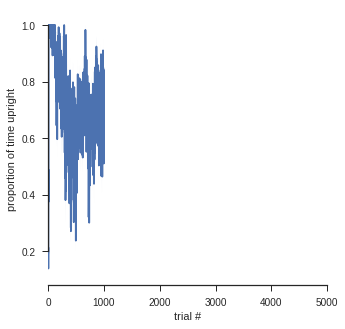

In [14]:
fig, axis = plt.subplots(1,1,figsize = (5,5))
#axis.plot(np.arange(5000),np.mean(theta<np.pi/8, 1))
sns.tsplot(np.mean(theta<np.pi/8, 1).T, ax = axis, ci=68)
axis.set_xlabel('trial #')
axis.set_xlim([0, 5000])
axis.set_ylabel('proportion of time upright')
sns.despine(trim=True)
#plt.savefig('./figues/fig_3_cartpole_bp.pdf')